In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
import planetary_computer
import pystac_client
import pystac
import rioxarray as rio
from shapely.geometry import shape
import stackstac
from xrspatial.multispectral import true_color
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
### define area of interest 
aoi_geom = shape({"coordinates": [[
            [-16.23283389828336,64.73320363719611],
            [-16.23283389828336,64.67564211186962],
            [-16.067809638159872,64.67564211186962],
            [-16.067809638159872,64.73320363719611],
            [-16.23283389828336,64.73320363719611]]
                                  ],"type": "Polygon"})

aoi = gpd.GeoDataFrame(geometry=[aoi_geom], crs=4326)

In [3]:
################# sentinel 2 scenes
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=["sentinel-2-l2a"],
                        intersects=aoi_geom,
                        datetime="2020-01-01/2023-12-31",
                        query={"eo:cloud_cover":{'lt':10}})

s2_items = search.item_collection()
s2_items = pystac.ItemCollection(
    [item for item in s2_items if 
     shape(item.to_dict()['geometry']).contains(aoi_geom)]
)

epsg = set([item.properties['proj:epsg'] for item in s2_items])
print(f'found {len(s2_items)} S2 items\nwith the following epsgs: {epsg}')

epsg_code = list(epsg)[0]
prj = ccrs.epsg(epsg_code)
aoi_prj = gpd.GeoDataFrame(geometry=[aoi_geom],crs=4326).to_crs(prj)['geometry'][0]

s2 = (stackstac.stack(planetary_computer.sign(s2_items),
                      epsg=epsg_code,
                      resolution=10)
      .rio.clip_box(*aoi_prj.bounds))

found 18 S2 items
with the following epsgs: {32628}


c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [4]:
# pick image, and get visible bands
rgb = s2[-5,[4,3,2],:,:].compute()
date = pd.to_datetime(rgb['time'].values)

## country outline and centroid
iceland = gpd.read_file('../day3_polygons/ne_10m_admin_0_countries.zip',
              where="name='Iceland'").to_crs(prj)
## get centr of aoi for plotting on inset
cntr = aoi_prj.centroid

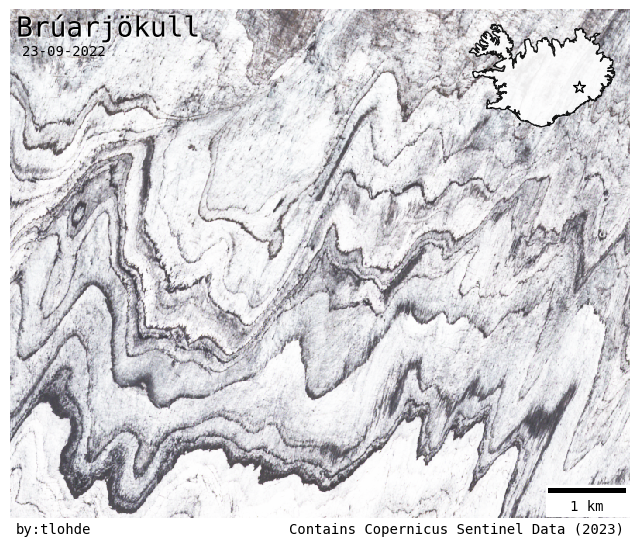

In [5]:
fig, ax = plt.subplots(figsize=[8,8], subplot_kw={'projection':prj})

# plot satellite image
true_color(*rgb).plot.imshow(rgb='band',ax=ax)

ax.set_axis_off()
ax.add_artist(ScaleBar(1, location='lower right'))

ax.set_title("Brúarjökull", loc='left',y=0.93,x=0.01,fontdict={'fontsize':20},
             path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='w',
                                                              alpha=0.9,
                                                              offset=(1,-1))])

ax.annotate(text = f"{date.strftime('%d-%m-%Y')}",
            xy=(0.02,0.91),
            xycoords='axes fraction',
            fontsize=10)

ax.annotate(text='Contains Copernicus Sentinel Data (2023)',
            xy=(0.99,-0.03), 
            xycoords='axes fraction',
            ha='right',
            fontsize=10,
            c='k')

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.03), 
            xycoords='axes fraction',
            ha='left',
            fontsize=10,
            c='k')

## add inset
inset=fig.add_axes(rect=(0.69,0.63,0.2,0.2))
iceland.plot(ax=inset, fc='w', alpha=0.9, ec='k')
inset.scatter(cntr.x,cntr.y, fc='w', ec='k', marker='*', s=80)
inset.set_axis_off()

fig.savefig('day24.png', bbox_inches='tight', dpi=300)